# Total Perspective Vortex
- Date: `14-07-2023 3:30PM`
- Third project in the AI branch of 42's system
- Project description: 
    - `Learn to use python tools to process large dimension data, and create a man-machine interface thanks to brainwaves.`
- Summary: 
    - `Brain computer interface with machine learning based on electoencephalographic data.`
    - This subject aims to create a brain computer interface based on electroencephalographic
data (EEG data) with the help of machine learning algorithms. Using a subject’s EEG
reading, you’ll have to infer what he or she is thinking about or doing - (motion) A or B
in a t0 to tn timeframe.
- Goals:
    - Process EEG datas (parsing and filtering)
    - Implement a dimensionality reduction algorithm
    - Use the pipeline object from scikit-learn
    - Classify a data stream in "real time"

  ##### Update 28th December 2023 - Continuing the ongoing work.
    - Set up environment.
    - Load data.
    - Filter out bad frequencies.
    - Analyze.
 
  ---


<img width="350" src="https://sipl.eelabs.technion.ac.il/wp-content/uploads/sites/6/2017/12/project-image-3966-2-16.png"></img>

---
## Steps:
V.1 Preprocessing, parsing and formating . <br>
V.2 Treatment pipeline . <br>
V.3 Implementation . <br>
V.4 Train, Validation and Test . <br>

---

#### we pick data related to hands vs feet
5, 9, 13 : Motor execution: hands vs feet <br>
6, 10, 14 : Motor imagery: hands vs feet <br>
read: https://mne.tools/dev/generated/mne.datasets.eegbci.load_data.html

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import pick_types
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.preprocessing import ICA 

mne.set_log_level("CRITICAL")

### Data loading:

- The code loads EEG data for executing and imagining motor tasks for specified subjects and runs.<br>
- For each subject and run combination, EEG data is loaded, and events corresponding to rest, foot movement, and hand movement are annotated.<br>
- Annotations are created for both executing and imagining motor tasks, and the annotations are set to the respective raw data.<br>
- The processed raw data is appended to the raw_files list.<br>
- This code is designed for loading and preprocessing EEG data for motor task execution and imagery, making it ready for further analysis.<br>

#### code details:
- **`mne.events_from_annotations`**: extracts events from annotations in the raw EEG data.<br>
It's applied separately to executing and imagining motor tasks.<br>
The event_id parameter maps annotation labels to event codes.
- **`mne.annotations_from_events`**: creates annotations from events.<br>
It maps events to descriptions using the provided mapping.<br>
Annotations include information about event timing and descriptions.
    - ##### Parameters:
        - `events`: Event array.
        - `event_desc`: Dictionary mapping event codes to descriptions.
        - `sfreq`: Sampling Frequency:<br>
            - In the context of EEG data, the sfreq parameter stands for the "sampling frequency" of the raw data.<br>
            - Sampling frequency represents the number of samples (data points) obtained per unit of time, usually expressed in Hertz (Hz).<br>
            - For EEG data, the sampling frequency indicates how many samples are collected per second. Higher sampling frequencies provide more temporal detail but may require more storage and processing resources.<br>
            - In this code, raw_execution.info['sfreq'] retrieves the sampling frequency from the information associated with the raw_execution object.
        - `orig_time`: Original measurement time of the raw data.<br>
            - The orig_time parameter represents the original measurement time of the raw EEG data.<br>
            - It indicates the specific time point when the EEG recording began.<br>
            - The information about the original measurement time is important for maintaining the temporal context of the EEG data.<br>
            - In this code, raw_execution.info['meas_date'] retrieves the original measurement time from the information associated with the raw_execution object.<br>


In [52]:
# EEG Data Loading and Annotation

# - T0 corresponds to rest
# - T1 corresponds to the onset of motion (real or imagined) of the left fist (in runs 3, 4, 7, 8, 11, and 12)
#   or both fists (in runs 5, 6, 9, 10, 13, and 14)
# - T2 corresponds to the onset of motion (real or imagined) of the right fist (in runs 3, 4, 7, 8, 11, and 12)
#   or both feet (in runs 5, 6, 9, 10, 13, and 14)

subject = [1]  # List of subject numbers (e.g., [1, 4])
run_execution = [5, 9, 13]  # Runs for executing motor tasks
run_imagery = [6, 10, 14]  # Runs for imagining motor tasks

raw_files = []

# Loop through each subject and associated runs for execution and imagery
for person_number in subject:
    for i, j in zip(run_execution, run_imagery):
        # Load EEG data for executing motor tasks
        raw_files_execution = [read_raw_edf(f, preload=True, stim_channel='auto') for f in eegbci.load_data(person_number, i)]
        raw_execution = concatenate_raws(raw_files_execution)

        # Load EEG data for imagining motor tasks
        raw_files_imagery = [read_raw_edf(f, preload=True, stim_channel='auto') for f in eegbci.load_data(person_number, j)]
        raw_imagery = concatenate_raws(raw_files_imagery)

        # Extract events and create annotations for executing motor tasks
        events, _ = mne.events_from_annotations(raw_execution, event_id=dict(T0=1, T1=2, T2=3))
        mapping = {1: 'rest', 2: 'do/feet', 3: 'do/hands'}
        annot_from_events = mne.annotations_from_events(
            events=events, event_desc=mapping, sfreq=raw_execution.info['sfreq'],
            orig_time=raw_execution.info['meas_date'])
        raw_execution.set_annotations(annot_from_events)

        # Extract events and create annotations for imagining motor tasks
        events, _ = mne.events_from_annotations(raw_imagery, event_id=dict(T0=1, T1=2, T2=3))
        mapping = {1: 'rest', 2: 'imagine/feet', 3: 'imagine/hands'}
        annot_from_events = mne.annotations_from_events(
            events=events, event_desc=mapping, sfreq=raw_imagery.info['sfreq'],
            orig_time=raw_imagery.info['meas_date'])
        raw_imagery.set_annotations(annot_from_events)

        # Append the processed raw data to the list
        raw_files.append(raw_execution)
        raw_files.append(raw_imagery)


array([[-1.0e-05,  1.0e-05,  1.7e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 2.0e-05,  5.0e-05,  5.5e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 7.0e-06,  4.9e-05,  5.9e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       ...,
       [ 2.4e-05,  2.5e-05,  3.4e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 8.9e-05,  8.3e-05,  9.2e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 6.8e-05,  6.5e-05,  7.8e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00]])

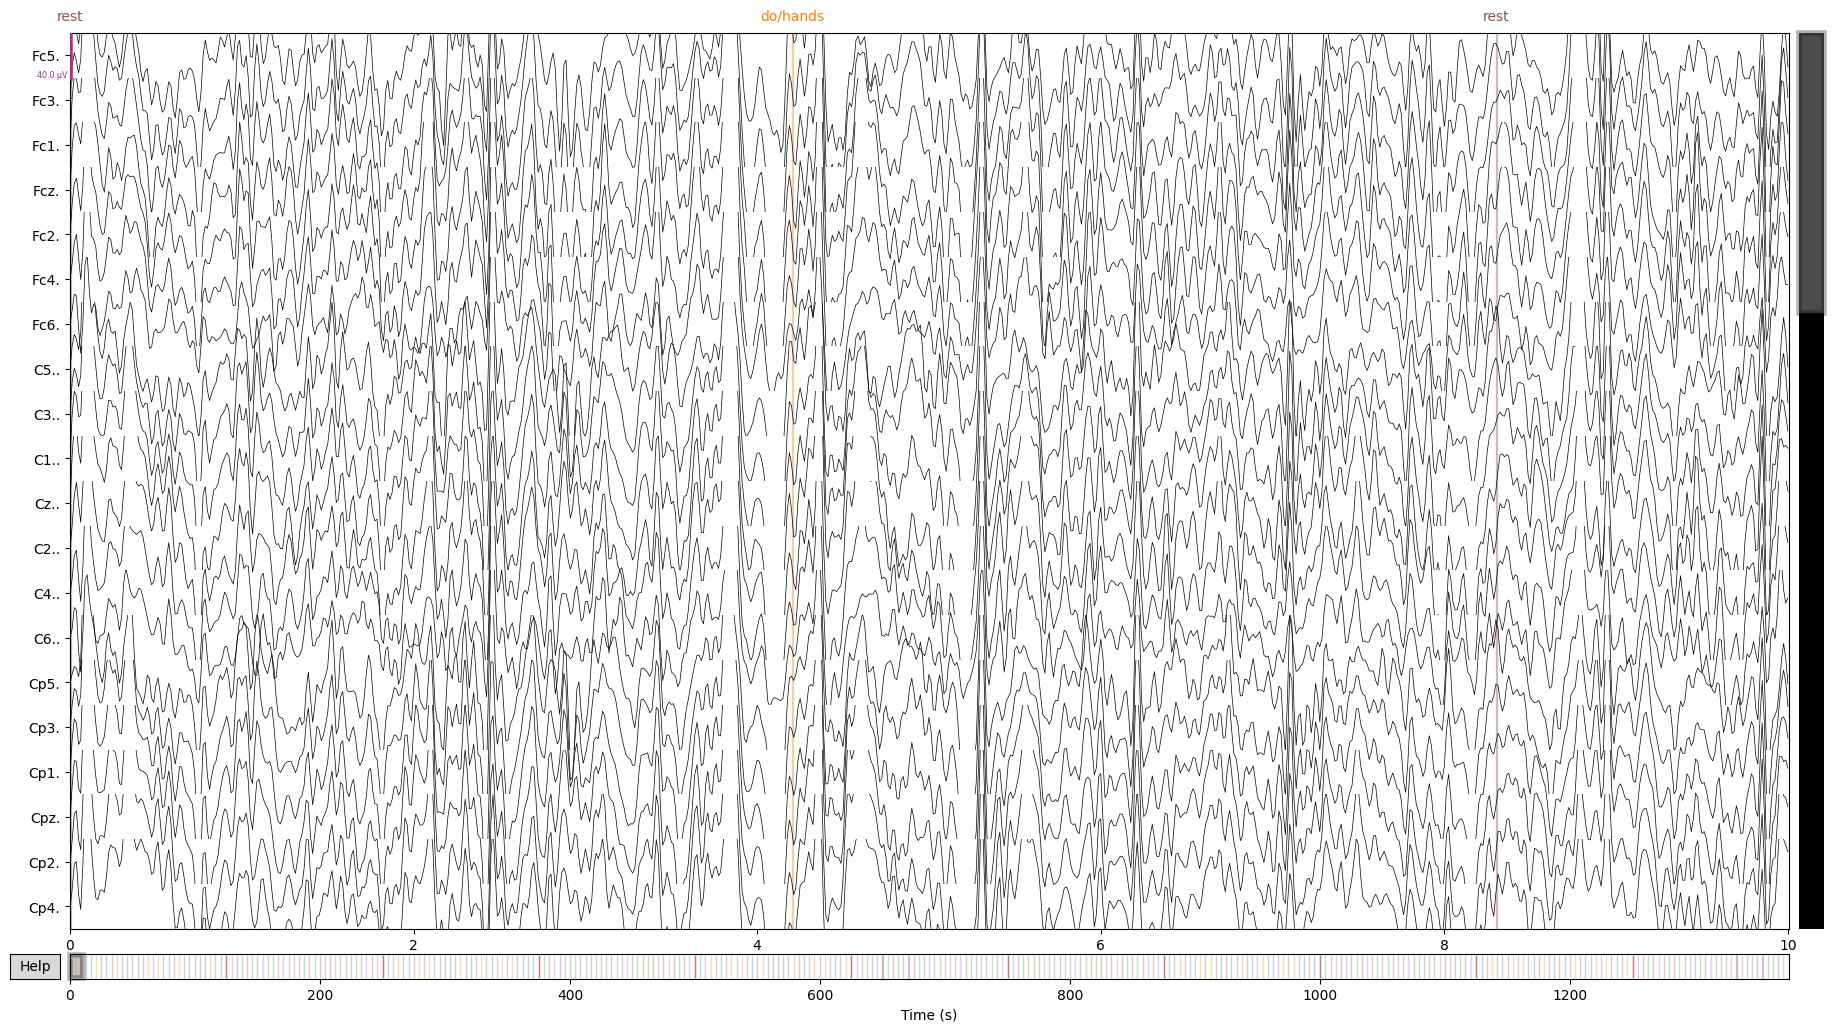

/tmp/ipykernel_7774/719434142.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [54]:
raw = concatenate_raws(raw_files)
events, event_dict = mne.events_from_annotations(raw)
data = raw.get_data()

# display(raw.info)
# display(event_dict)
# display(raw.ch_names)
display(data)
raw.filter(1,20)
fig = raw.plot()
fig.show()

In [50]:
#filter any bad channels that were identified to have artifacts
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
print(picks)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


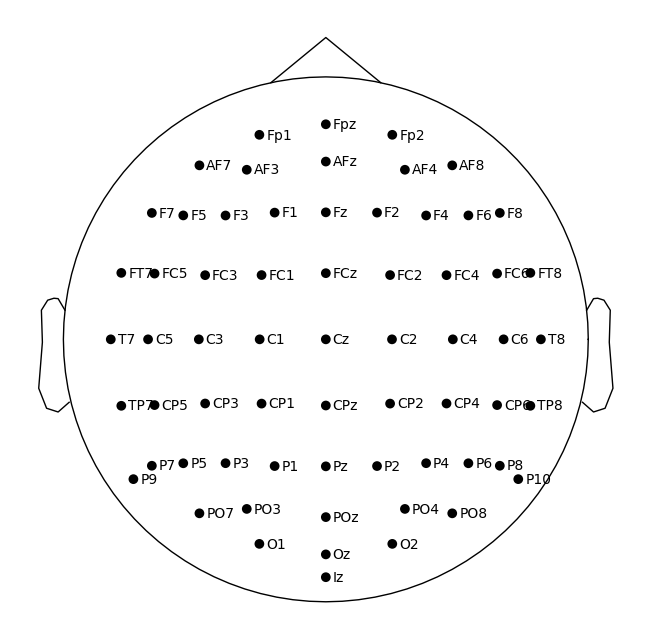

In [36]:
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
biosemi_montage.plot()
plt.show()

Sets the EEG channel names and applies a standard EEG montage, which includes digitization points for the EEG electrodes.

This is a common and necessary step when working with EEG data in MNE-Python.

- `eegbci.standardize(raw)`: This function is used to standardize the channel names of the EEG data. It ensures that the channel names follow a consistent naming convention, making it easier to work with standard montages.

- `make_standard_montage('standard_1005')`: This function creates a standard EEG electrode montage based on the 10/05 system, which is a widely used electrode placement system. It defines the positions of EEG electrodes on the scalp.

- `raw.set_montage(montage)`: This line sets the electrode montage for the raw object to the standardized montage created in the previous step. Setting the montage ensures that the digitization points are available in the info attribute of the raw object.

In [37]:
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

Measurement date,"August 12, 2009 16:15:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,67 points
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,160.00 Hz
Highpass,1.00 Hz
Lowpass,20.00 Hz


##  Independent Component Analysis (ICA) 

##### perform Independent Component Analysis (ICA) on EEG data to identify and visualize independent components. 
##### It specifically focuses on identifying components related to eye movements (EOG artifacts) and prints the indices of the identified "bad" components. 
##### These components can then be excluded from further analysis or removed from the data to enhance the quality of EEG recordings.
- `rawClone = raw.copy()`: This line creates a copy of the raw EEG data. The raw object is typically an instance of the mne.io.Raw class representing continuous EEG data. Creating a copy (rawClone) is a common practice to avoid modifying the original data during processing.
- `ica = ICA(n_components=20, method='fastica', random_state=97)`: This line initializes an Independent Component Analysis (ICA) object. ICA is a technique used for blind source separation and is commonly applied to EEG data to identify and remove artifacts. The parameters specified include:
    - `n_components=20`: Specifies the number of independent components to estimate. In this case, it's set to 20.
    - `method='fastica'`: Specifies the ICA algorithm to use. 'fastica' is a commonly used algorithm for EEG artifact removal.
    - `random_state=97`: Sets the random seed for reproducibility. The same seed ensures that the results are consistent across runs.
- `ica.fit(rawClone, picks=picks)`: This line fits the ICA model to the EEG data (rawClone). The picks parameter is used to specify the subset of channels on which to perform the ICA. It's a good practice to limit the ICA to relevant channels, often excluding certain channels like EOG (electrooculogram) or other non-EEG channels.

- `ica.plot_components()`: This line generates a plot of the independent components estimated by the ICA. The purpose of this plot is to visually inspect the components and identify those that correspond to artifacts (such as eye blinks, muscle activity) as opposed to neural sources.

- `eog_indicies, scores= ica.find_bads_eog(raw, ch_name='Fpz', threshold=1.5)`: This line identifies "bad" independent components that likely represent artifacts related to eye movements. It uses the find_bads_eog method, which leverages information about the EOG channels ('Fpz' in this case) to identify components associated with eye movements. The threshold parameter determines the sensitivity of the algorithm.

- `print("Bad indicies: " + str(eog_indicies))`: This line prints the indices of the identified "bad" independent components. These components can be further inspected and potentially removed from the EEG data to improve data quality.

Bad indicies: [0]


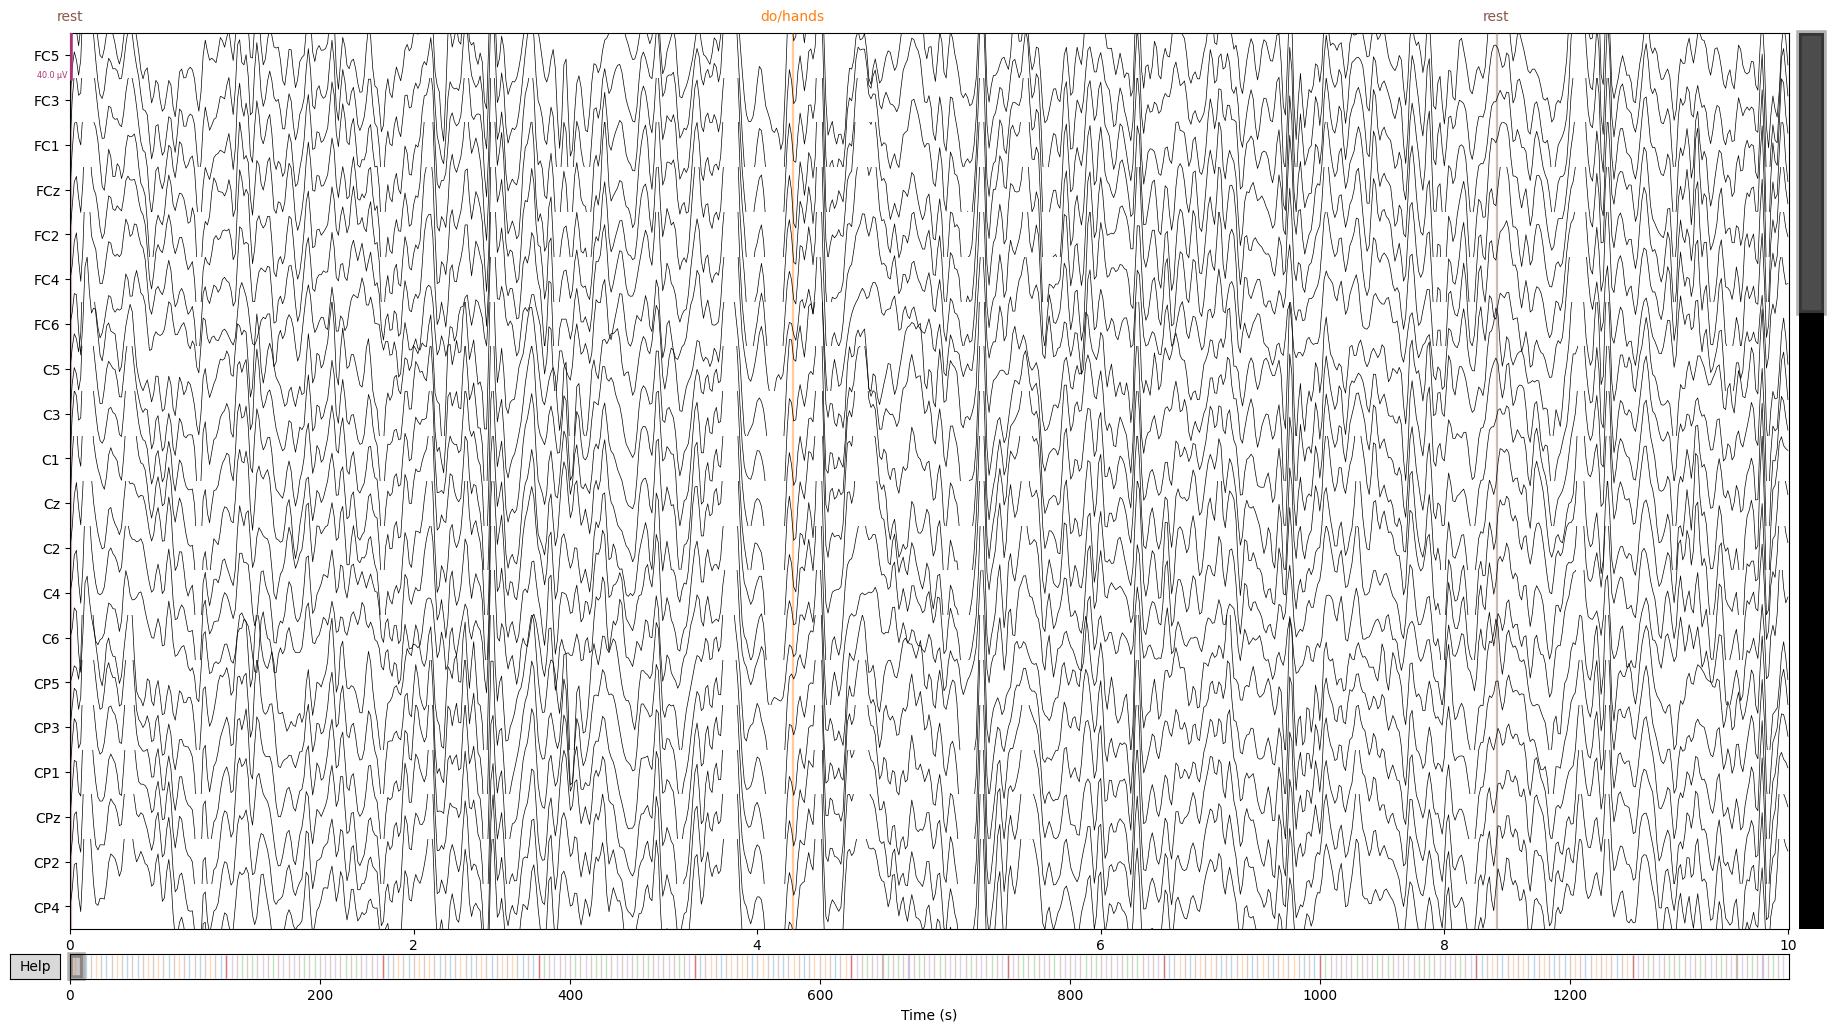

/tmp/ipykernel_7774/157031001.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [38]:
rawClone = raw.copy()
ica = ICA(n_components=20, method='fastica', random_state=97)
ica.fit(rawClone, picks=picks)
eog_indicies, scores= ica.find_bads_eog(raw, ch_name='Fpz', threshold=1.5)
print("Bad indicies: " + str(eog_indicies))
fig = raw.plot()
fig.show()

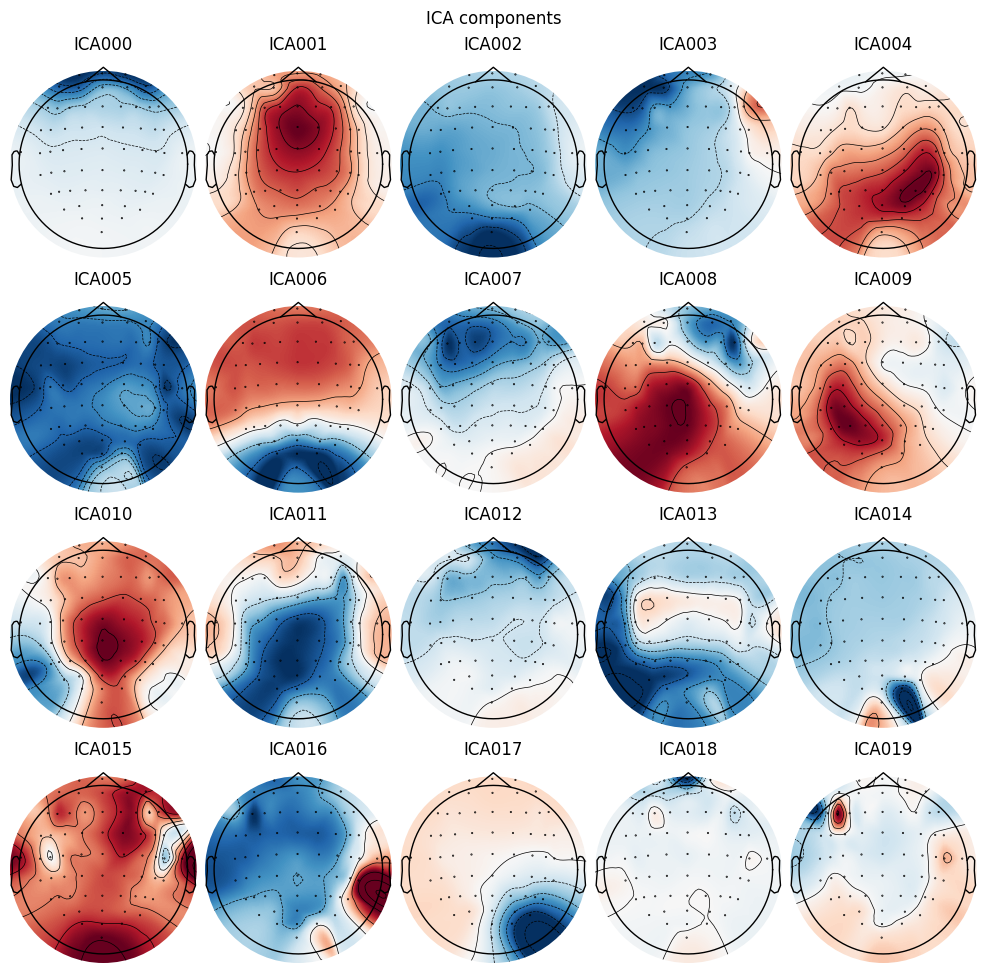

/tmp/ipykernel_7774/2914340926.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [39]:
fig = ica.plot_components()
fig.show()